# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('reviews.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final_data.shape)

#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
import re
i=0;
for sent in final_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break
    i += 1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = stopwords.words('english')
stop = set(stopwords) 
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

if not os.path.isfile('final_data.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    s=''
    for sent in tqdm(final_data['Text'].values):
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final_data['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s)
                        if(final_data['Score'].values)[i] == 'negative':
                            all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence)

        final_string.append(str1)
        i+=1

    final_data['CleanedText']=final_string
    final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")
    conn = sqlite3.connect('final_data.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chaitanyareddypatlolla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
if os.path.isfile('final_data.sqlite'):
    conn = sqlite3.connect('final_data.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [18]:
final.shape

(364171, 12)

# Sorting & Splitting the data:

In [19]:
final = final.sort_values('Time') #Sorting based on time


final= final[:100000] #After sorting data based on time, we're taking a sample of 100k points

In [20]:
final['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [21]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

final_points= final['CleanedText']
labels = final['Score']

X_1, X_test, y_1, y_test = model_selection.train_test_split(final, labels, test_size=0.3, random_state=0)

X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3)


X_tr.shape, X_test.shape, X_cv.shape

((49000, 12), (30000, 12), (21000, 12))

# [4] Featurization

## [4.1] BAG OF WORDS

In [22]:
#BoW
count_vect = CountVectorizer()
X_tr_bow = count_vect.fit_transform(X_tr['CleanedText'].values)
X_cv_bow = count_vect.transform(X_cv['CleanedText'].values)
X_test_bow = count_vect.transform(X_test['CleanedText'].values)

In [23]:
X_tr_bow.shape, X_cv_bow.shape,X_test_bow.shape

((49000, 26617), (21000, 26617), (30000, 26617))

## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [98]:
tf_idf_vect = TfidfVectorizer(min_df= 10)
X_tr_tf_idf = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
X_cv_tf_idf = tf_idf_vect.transform(X_cv['CleanedText'].values)
X_test_tf_idf = tf_idf_vect.transform(X_test['CleanedText'].values)

## [4.4] Word2Vec

In [123]:
# Train your own Word2Vec model using your own text corpus
i=0
train_sent_list=[]
for sent in X_tr['CleanedText'].values:
    train_sent_list.append(sent.split())
    
i=0
cv_sent_list=[]
for sent in X_cv['CleanedText'].values:
    cv_sent_list.append(sent.split())   


i=0
test_sent_list=[]
for sent in X_test['CleanedText'].values:
    test_sent_list.append(sent.split())

In [124]:
from gensim.models import Word2Vec

train_w2v_model= Word2Vec(train_sent_list,min_count=5,size=50, workers=4)
train_w2v_words = list(train_w2v_model.wv.vocab)

cv_w2v_model= Word2Vec(cv_sent_list,min_count=5,size=50, workers=4)
cv_w2v_words = list(cv_w2v_model.wv.vocab)

test_w2v_model= Word2Vec(test_sent_list,min_count=5,size=50, workers=4)
test_w2v_words = list(test_w2v_model.wv.vocab)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [125]:
#Training data for average w2v

train_sent_vectors = []
for sent in tqdm(train_sent_list):
    train_sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in train_w2v_words:
            vec = train_w2v_model.wv[word]
            train_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        train_sent_vec /= cnt_words
    train_sent_vectors.append(train_sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

100%|██████████| 49000/49000 [05:20<00:00, 153.04it/s]

49000
50


In [126]:
#CV data for average w2v

cv_sent_vectors = []
for sent in tqdm(cv_sent_list):
    cv_sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in cv_w2v_words:
            vec = cv_w2v_model.wv[word]
            cv_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        cv_sent_vec /= cnt_words
    cv_sent_vectors.append(cv_sent_vec)
print(len(cv_sent_vectors))
print(len(cv_sent_vectors[0]))

100%|██████████| 21000/21000 [01:09<00:00, 304.33it/s]

21000
50


In [127]:
#Test data for average w2v

test_sent_vectors = []
for sent in tqdm(test_sent_list):
    test_sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in test_w2v_words:
            vec = test_w2v_model.wv[word]
            test_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        test_sent_vec /= cnt_words
    test_sent_vectors.append(test_sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

100%|██████████| 30000/30000 [02:06<00:00, 237.16it/s]

30000
50


#### [4.4.1.2] TFIDF weighted W2v

In [133]:
model = TfidfVectorizer()
train_matrix = model.fit_transform(X_tr['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

train_feat = model.get_feature_names()

train_vectors = [];
row=0;
for sent in tqdm(train_sent_list):
    train_sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        if word in train_w2v_words:
            train_vec = train_w2v_model.wv[word]
            train_tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            train_sent_vec += (vec * train_tf_idf)
            weight_sum += train_tf_idf
    if weight_sum != 0:
        train_sent_vec /= weight_sum
    train_vectors.append(train_sent_vec)
    row += 1

100%|██████████| 49000/49000 [05:55<00:00, 137.78it/s]


In [134]:
model = TfidfVectorizer()
cv_matrix = model.fit_transform(X_cv['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

cv_feat = model.get_feature_names()

cv_vectors = [];
row=0;
for sent in tqdm(cv_sent_list):
    cv_sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        if word in cv_w2v_words:
            cv_vec = cv_w2v_model.wv[word]
            cv_tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            cv_sent_vec += (vec * cv_tf_idf)
            weight_sum += cv_tf_idf
    if weight_sum != 0:
        cv_sent_vec /= weight_sum
    cv_vectors.append(cv_sent_vec)
    row += 1

100%|██████████| 21000/21000 [01:18<00:00, 269.19it/s]


In [135]:
model = TfidfVectorizer()
test_matrix = model.fit_transform(X_test['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

test_feat = model.get_feature_names()

test_vectors = [];
row=0;
for sent in tqdm(test_sent_list):
    test_sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        if word in test_w2v_words:
            test_vec = test_w2v_model.wv[word]
            test_tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            test_sent_vec += (vec * test_tf_idf)
            weight_sum += test_tf_idf
    if weight_sum != 0:
        test_sent_vec /= weight_sum
    test_vectors.append(train_sent_vec)
    row += 1

100%|██████████| 30000/30000 [02:30<00:00, 199.22it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [24]:
#Performing Column standardization on train and cv data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tr_bow= scaler.fit_transform(X_tr_bow)

X_tr_bow= scaler.fit_transform(X_tr_bow)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

tr_list = []
for i in c:
    lr = LogisticRegression(penalty='l1', C=i, n_jobs=-1)
    lr.fit(X_tr_bow, y_tr)
    pred = lr.predict(X_tr_bow)
    auc = roc_auc_score(y_tr, pred)
    tr_list.append(auc.mean())
    print('\nTrain auc for C = %f is %f%%' % (i, auc))

print('*'*100)

cv_list = []
for j in c:
    lr = LogisticRegression(penalty='l1', C=j, n_jobs=-1)
    lr.fit(X_tr_bow, y_tr)
    pred = lr.predict(X_cv_bow)
    auc = roc_auc_score(y_cv, pred)
    cv_list.append(auc.mean())
    print('\nCV auc for C = %f is %f%%' % (j, auc))


Train auc for C = 0.000010 is 0.500000%

Train auc for C = 0.000100 is 0.500000%

Train auc for C = 0.001000 is 0.525236%

Train auc for C = 0.010000 is 0.788717%

Train auc for C = 0.100000 is 0.936016%

Train auc for C = 1.000000 is 0.978040%

Train auc for C = 10.000000 is 0.986433%

Train auc for C = 100.000000 is 0.988744%

Train auc for C = 1000.000000 is 0.987271%

Train auc for C = 10000.000000 is 0.987659%
****************************************************************************************************

CV auc for C = 0.000010 is 0.500000%

CV auc for C = 0.000100 is 0.500000%

CV auc for C = 0.001000 is 0.500000%

CV auc for C = 0.010000 is 0.501176%

CV auc for C = 0.100000 is 0.522981%

CV auc for C = 1.000000 is 0.570328%

CV auc for C = 10.000000 is 0.587966%

CV auc for C = 100.000000 is 0.577359%

CV auc for C = 1000.000000 is 0.580360%

CV auc for C = 10000.000000 is 0.582294%


In [28]:
import math

c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

c =  [math.log(i) for i in c] #Applying log(alpha) for better visualization

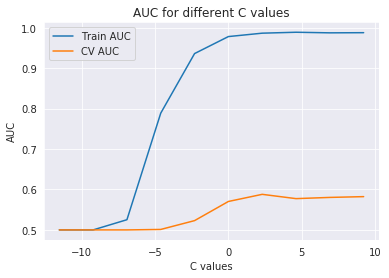

In [29]:
sns.set_style("darkgrid")
plt.plot(c, tr_list, label= 'Train AUC')
plt.plot(c, cv_list, label= 'CV AUC')
plt.xlabel("C values")
plt.ylabel("AUC")
plt.title("AUC for different C values")
plt.legend()
plt.show()

### Observation:
From the above table and data we can observe that the optimal value of C is 10 with CV AUC score of 0.587

In [27]:
lr = LogisticRegression(penalty='l1', C=10, n_jobs=-1)
lr.fit(X_tr_bow, y_tr)
pred = lr.predict(X_test_bow)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 10 is %f%%' % (auc))


****Test auc for C = 10 is 0.577235%


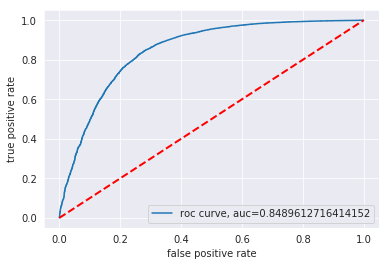

In [30]:
lw = 2
pred_proba = lr.predict_proba(X_test_bow)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  pred_proba)
auc = metrics.roc_auc_score(y_test, pred_proba)
plt.plot(fpr,tpr,label="roc curve, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.show()

### Obeservation:
The ROC curve of BOW with L1 regularizer is above the random line and seperated by a good distance

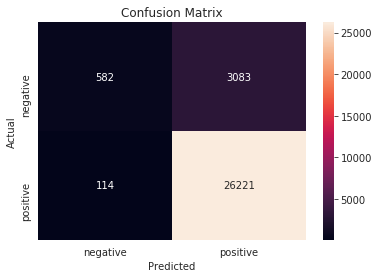

In [31]:
conf_matrix = confusion_matrix(y_test, pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Observation:
True Negative = 582, True Positive = 26221, False Negative = 114, False Positive = 3083

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [32]:
lr = LogisticRegression(penalty='l1', C=1, n_jobs=-1)
lr.fit(X_tr_bow, y_tr)
pred = lr.predict(X_test_bow)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 1 is %f%%' % (auc))


print("Non Zero weights at C=1 are:",np.count_nonzero(lr.coef_)) #Sparsity on weight vector obtained by L1 on BoW


****Test auc for C = 1 is 0.566145%
Non Zero weights at C=1 are: 9352


In [33]:
lr = LogisticRegression(penalty='l1', C=10, n_jobs=-1)
lr.fit(X_tr_bow, y_tr)
pred = lr.predict(X_test_bow)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 10 is %f%%' % (auc))


print("Non Zero weights at C=10 are:",np.count_nonzero(lr.coef_))


****Test auc for C = 10 is 0.576962%
Non Zero weights at C=10 are: 12740


In [34]:
lr = LogisticRegression(penalty='l1', C=100, n_jobs=-1)
lr.fit(X_tr_bow, y_tr)
pred = lr.predict(X_test_bow)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 100 is %f%%' % (auc))


print("Non Zero weights at C=100 are:",np.count_nonzero(lr.coef_))


****Test auc for C = 100 is 0.576007%
Non Zero weights at C=100 are: 16355


### Observation:

When L1 regularization is applied with BoW, the sparsity on weight vectors decreases i.e., the number of non zero values increases with the increase in the value of hyperparameter C.

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [36]:
c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

tr_list = []
for i in c:
    lr = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    lr.fit(X_tr_bow, y_tr)
    pred = lr.predict(X_tr_bow)
    auc = roc_auc_score(y_tr, pred)
    tr_list.append(auc.mean())
    print('\nTrain auc for C = %f is %f%%' % (i, auc))

print('*'*100)

cv_list = []
for j in c:
    lr = LogisticRegression(penalty='l2', C=j, n_jobs=-1)
    lr.fit(X_tr_bow, y_tr)
    pred = lr.predict(X_cv_bow)
    auc = roc_auc_score(y_cv, pred)
    cv_list.append(auc.mean())
    print('\nCV auc for C = %f is %f%%' % (j, auc))


Train auc for C = 0.000010 is 0.544797%

Train auc for C = 0.000100 is 0.783663%

Train auc for C = 0.001000 is 0.902303%

Train auc for C = 0.010000 is 0.950860%

Train auc for C = 0.100000 is 0.973924%

Train auc for C = 1.000000 is 0.986493%

Train auc for C = 10.000000 is 0.993246%

Train auc for C = 100.000000 is 0.993870%

Train auc for C = 1000.000000 is 0.983440%

Train auc for C = 10000.000000 is 0.983487%
****************************************************************************************************

CV auc for C = 0.000010 is 0.500000%

CV auc for C = 0.000100 is 0.500196%

CV auc for C = 0.001000 is 0.502941%

CV auc for C = 0.010000 is 0.521014%

CV auc for C = 0.100000 is 0.553953%

CV auc for C = 1.000000 is 0.583917%

CV auc for C = 10.000000 is 0.600985%

CV auc for C = 100.000000 is 0.603007%

CV auc for C = 1000.000000 is 0.575412%

CV auc for C = 10000.000000 is 0.575608%


In [37]:
c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

c =  [math.log(i) for i in c] #Applying log(alpha) for better visualization

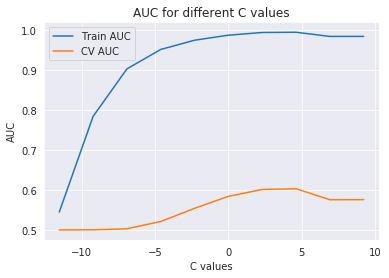

In [38]:
sns.set_style("darkgrid")
plt.plot(c, tr_list, label= 'Train AUC')
plt.plot(c,cv_list, label= 'CV AUC')
plt.xlabel("C values")
plt.ylabel("AUC")
plt.title("AUC for different C values")
plt.legend()
plt.show()

### Observation:
From the above table and data we can observe that the optimalvalue of C is 100 with CV AUC score of 0.603

In [47]:
w= lr.coef_

lr = LogisticRegression(penalty='l2', C=100, n_jobs=-1)
lr.fit(X_tr_bow, y_tr)
pred = lr.predict(X_test_bow)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 100 is %f%%' % (auc))


print("Non Zero weights at C = 100 are:",np.count_nonzero(w)) #Sparsity on weight vector obtained by L2 on BoW


****Test auc for C = 100 is 0.582604%
Non Zero weights at C = 100 are: 26617


## Observation:

The non-zero weights when L1 regularization applied on BoW with C as 100 = 16355

The non-zero weights when L2 regularization applied on BoW with C as 100 = 26617

There is a massive difference in the no. of zero values when L1 regularization and L2 regularizations are applied

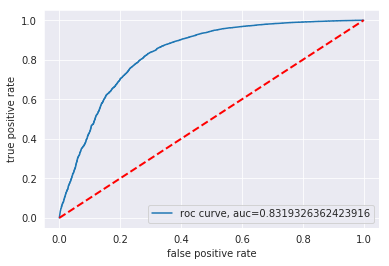

In [40]:
lw = 2
pred_proba = lr.predict_proba(X_test_bow)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  pred_proba)
auc = metrics.roc_auc_score(y_test, pred_proba)
plt.plot(fpr,tpr,label="roc curve, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.show()

### Obeservation:
The ROC curve of BOW with L2 regularization is above the random line and seperated by a good distance

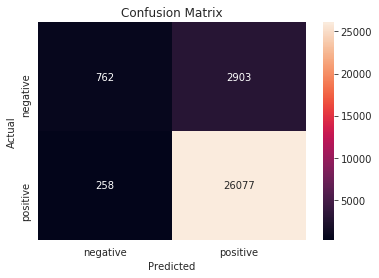

In [41]:
conf_matrix = confusion_matrix(y_test, pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Observation:
True Negative = 762, True Positive = 26077, False Negative = 258, False Positive = 2903

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [48]:
#Reference: https://github.com/nishantml/Logistic-Regression-detailed-implementation/blob/master/Logistic%20Regression.ipynb (Performing perturbation test)

#After getting the weights W after fit your model with the train data.
#Adding noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e) that is e = 0.01
                       
print(X_tr_bow.shape);
Standardize_x_tr_bow = X_tr_bow
Standardize_x_tr_bow.data = Standardize_x_tr_bow.data + 0.01
print(Standardize_x_tr_bow.shape)

(49000, 26617)
(49000, 26617)


In [49]:
#Training on train data having random noise

lr = LogisticRegression(penalty='l2', C=100, n_jobs=-1)
lr.fit(Standardize_x_tr_bow, y_tr)
w_dash = lr.coef_
pred = lr.predict(X_test_bow)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 100 is %f%%' % (auc))


print("Non Zero weights at C = 100 are:",np.count_nonzero(w_dash))


****Test auc for C = 100 is 0.574913%
Non Zero weights at C = 100 are: 26617


In [50]:
w = w[0] + 0.000001
w_dash = w_dash[0] +0.000001
W = list(w)
W_Dash = list(w_dash)

In [52]:
#finding the % change between W and W' (| (W-W') / (W) |)*100)

change_vector_percentage = []
for i in tqdm(range(0,len(W))):
    change_vector = 0
    change_vector=(abs((W[i]-(W_Dash[i]))/(W[i])))*100
    change_vector_percentage.append(change_vector)

100%|██████████| 26617/26617 [00:00<00:00, 846840.19it/s]


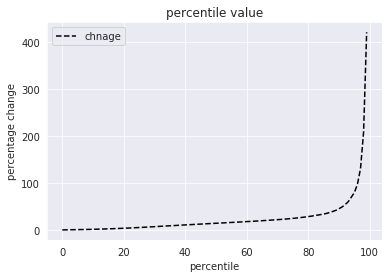

In [53]:
#calculating the 0th, 10th, 20th, 30th, ...100th percentiles, and observing any sudden rise in the values of percentage_change_vector

percentile_value = []
percentile = []
i= 0
while i <100:
    percentile.append(i)
    percentile_value.append(np.percentile(change_vector_percentage,i))
    i = i+1;
    
# percentile_value
plt.plot(percentile, percentile_value, 'k--',label='chnage')
plt.xlabel('percentile')
plt.ylabel('percentage change')
plt.title("percentile value")
plt.legend()
plt.show()

##### Observation:
As we can see above there is a sudden raise between 90 and 100

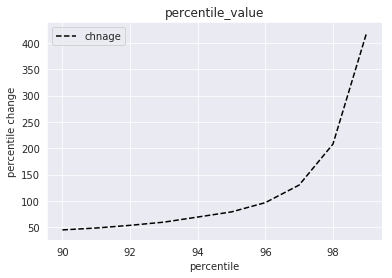

Percentile value from 90 to 99

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[45.12079040719262, 48.75475219829979, 53.804963731631496, 59.865805395308136, 69.52505304845418, 79.28111978015633, 96.87614829039795, 130.21596933550035, 207.962728832516, 420.0449366403286]


In [54]:
ninty_percentile_val = []
ninty_percentile = []
j= 90
while j <100:
    ninty_percentile.append(j)
    ninty_percentile_val.append(np.percentile(change_vector_percentage,j))
    j = j+1;
    
plt.plot(ninty_percentile, ninty_percentile_val, 'k--',label='chnage')
plt.xlabel('percentile')
plt.ylabel('percentile change')
plt.title("percentile_value")
plt.legend()
plt.show()

print("Percentile value from 90 to 99\n")
print(ninty_percentile)
print(ninty_percentile_val)

##### Observation:
From the above graph and data we can observe that there is a drastic change between 97 and 99

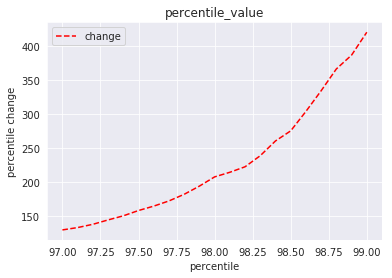

Percentile value from 97.0 to 99.0

[97, 97.1, 97.19999999999999, 97.29999999999998, 97.39999999999998, 97.49999999999997, 97.59999999999997, 97.69999999999996, 97.79999999999995, 97.89999999999995, 97.99999999999994, 98.09999999999994, 98.19999999999993, 98.29999999999993, 98.39999999999992, 98.49999999999991, 98.59999999999991, 98.6999999999999, 98.7999999999999, 98.89999999999989, 98.99999999999989]
[130.21596933550035, 133.66114912969564, 138.44242135646735, 144.8632656030143, 150.8624240624944, 158.66705648382205, 165.09385082591214, 172.70640866539335, 182.41305679319797, 194.42593448469992, 207.962728832516, 214.7137837327017, 222.77992653387287, 239.03564218737864, 260.65602984735557, 275.4378850483848, 303.9338406386247, 334.2261994782286, 366.23207706797746, 386.49200542583276, 420.0449366401578]


In [56]:
ninty_percentile_val = []
ninty_percentile = []
j= 97
while j <=99:
    ninty_percentile.append(j)
    ninty_percentile_val.append(np.percentile(change_vector_percentage,j))
    j = j+0.1;
    
plt.plot(ninty_percentile, ninty_percentile_val, 'r--',label='change')
plt.xlabel('percentile')
plt.ylabel('percentile change')
plt.title("percentile_value")
plt.legend()
plt.show()

print("Percentile value from 97.0 to 99.0\n")
print(ninty_percentile)
print(ninty_percentile_val)

##### Observation:

As we can see above at 98.3 percentile we got our elbow and the value at that is 239.0 and that is our thresold
and after getting threshold the features I will print which has more than threshold why? -- they are the features which are affected by simple noise, so they are multicollinear with some other features if any of these features are in important features then we can't trust the top features.

In [57]:
w_with_greater_than_thresold = []
count = 0;
for i in range(0,len(change_vector_percentage)):
    if change_vector_percentage[i] > 239.03:
        count = count +1;
        w_with_greater_than_thresold.append(w[i])
    else:
        w_with_greater_than_thresold.append(0.0)
        
print(count)

453


In [59]:
def collinear_features(vectorizer, w):
    feature_names = vectorizer.get_feature_names()
    topn_class2 = sorted(zip(w, feature_names), reverse=True)[:] 
    features_list = []
    for coef, feat in topn_class2:
        if coef != 0.0 :
            features_list.append(feat)
                
    collinear_features = features_list
    return collinear_features

In [60]:
features_with_greater_than_thresold = collinear_features(count_vect,w_with_greater_than_thresold)
print(features_with_greater_than_thresold)

['praiseworthi', 'overtook', 'curser', 'wireless', 'debut', 'crape', 'hiss', 'bouillion', 'pseudo', 'arrow', 'traditionalist', 'efagold', 'johanna', 'galt', 'further', 'catalyz', 'onboard', 'symbol', 'kindl', 'unintend', 'pardon', 'react', 'synergi', 'function', 'nutella', 'rico', 'financi', 'german', 'des', 'unseason', 'puerto', 'load', 'asset', 'mexican', 'whichev', 'mad', 'reduc', 'prune', 'partnership', 'asap', 'mere', 'extern', 'eschew', 'liaison', 'bolster', 'ecopod', 'tikka', 'cornucopia', 'mega', 'big', 'histori', 'las', 'regard', 'collin', 'underwhelm', 'winto', 'alberton', 'concret', 'someth', 'improv', 'job', 'lhasa', 'kit', 'spirulina', 'overproduc', 'litani', 'rancha', 'chopstickful', 'chocolati', 'domest', 'gimmicki', 'redirect', 'garganelli', 'forti', 'resourc', 'express', 'biloba', 'domata', 'candl', 'ohhh', 'sharki', 'gato', 'plenti', 'pile', 'fecal', 'breadman', 'flatten', 'reboot', 'defrag', 'condit', 'thinkof', 'tryin', 'lakesid', 'neoguri', 'koran', 'homegrown', 'v

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [64]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_2, fn_2, coef_1, fn_1))

In [65]:
show_most_informative_features(count_vect,lr)

			Positive				Negative
________________________________________________________________________________________________
	2.1095	great          				-1.2972	worst          
	1.8928	best           				-1.1384	disappoint     
	1.8103	love           				-0.9049	gram           
	1.6242	delici         				-0.8222	odor           
	1.5050	favorit        				-0.7930	would          
	1.3707	addict         				-0.7881	terribl        
	1.3351	perfect        				-0.7565	horribl        
	1.3240	excel          				-0.7366	slap           
	1.3150	refresh        				-0.7067	action         
	1.2898	rooibo         				-0.6926	protect        


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [3]:
# Please write all the code with proper documentation

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [99]:
c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

tr_list = []
for i in c:
    lr = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    lr.fit(X_tr_tf_idf, y_tr)
    pred = lr.predict(X_tr_tf_idf)
    auc = roc_auc_score(y_tr, pred)
    tr_list.append(auc.mean())
    print('\nTrain auc for C = %f is %f%%' % (i, auc))

print('*'*100)

cv_list = []
for j in c:
    lr = LogisticRegression(penalty='l2', C=j, n_jobs=-1)
    lr.fit(X_tr_tf_idf, y_tr)
    pred = lr.predict(X_cv_tf_idf)
    auc = roc_auc_score(y_cv, pred)
    cv_list.append(auc.mean())
    print('\nCV auc for C = %f is %f%%' % (j, auc))


Train auc for C = 0.000010 is 0.500000%

Train auc for C = 0.000100 is 0.500000%

Train auc for C = 0.001000 is 0.500000%

Train auc for C = 0.010000 is 0.500000%

Train auc for C = 0.100000 is 0.563886%

Train auc for C = 1.000000 is 0.762529%

Train auc for C = 10.000000 is 0.855374%

Train auc for C = 100.000000 is 0.896405%

Train auc for C = 1000.000000 is 0.916842%

Train auc for C = 10000.000000 is 0.921722%
****************************************************************************************************

CV auc for C = 0.000010 is 0.500000%

CV auc for C = 0.000100 is 0.500000%

CV auc for C = 0.001000 is 0.500000%

CV auc for C = 0.010000 is 0.500000%

CV auc for C = 0.100000 is 0.557072%

CV auc for C = 1.000000 is 0.735713%

CV auc for C = 10.000000 is 0.779325%

CV auc for C = 100.000000 is 0.783248%

CV auc for C = 1000.000000 is 0.771565%

CV auc for C = 10000.000000 is 0.763948%


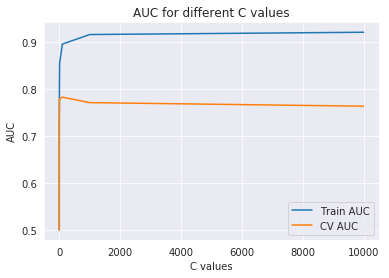

In [100]:
sns.set_style("darkgrid")
plt.plot(c, tr_list, label= 'Train AUC')
plt.plot(c,cv_list, label= 'CV AUC')
plt.xlabel("C values")
plt.ylabel("AUC")
plt.title("AUC for different C values")
plt.legend()
plt.show()

### Observation:
From the above table and data we can observe that the optimalvalue of C is 100 with CV AUC score of 0.783

In [102]:
lr = LogisticRegression(penalty='l2', C=100, n_jobs=-1)
lr.fit(X_tr_tf_idf, y_tr)
pred = lr.predict(X_test_tf_idf)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 10 is %f%%' % (auc))


****Test auc for C = 10 is 0.781207%


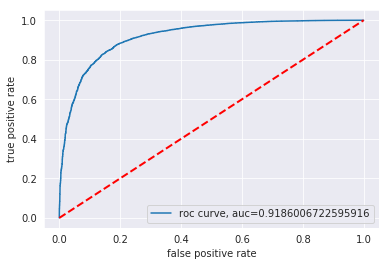

In [103]:
lw = 2
pred_proba = lr.predict_proba(X_test_tf_idf)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  pred_proba)
auc = metrics.roc_auc_score(y_test, pred_proba)
plt.plot(fpr,tpr,label="roc curve, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.show()

### Obeservation:
The ROC curve of TF-IDF with L2 regularization is above the random line and seperated by a good distance

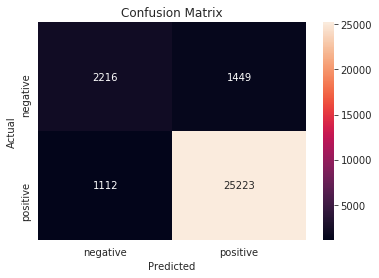

In [105]:
conf_matrix = confusion_matrix(y_test, pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Observation:
True Negative = 2216, True Positive = 25223, False Negative = 1112, False Positive = 1449

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [121]:
show_most_informative_features(tf_idf_vect,lr)

			Positive				Negative
________________________________________________________________________________________________
	-21.6668	great          				17.9301	worst          
	-19.4400	beat           				16.9532	decept         
	-15.4088	delici         				16.5997	deceiv         
	-15.3952	best           				16.1349	colada         
	-15.2241	aliv           				15.7814	fragment       
	-15.0372	danish         				15.1607	margin         
	-14.0747	mmmmm          				14.9261	angri          
	-14.0593	solv           				14.8825	unaccept       
	-13.6011	endless        				14.8695	surf           
	-13.4215	amaz           				14.6899	unsatisfi      


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [128]:
c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

tr_list = []
for i in c:
    lr = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    lr.fit(train_sent_vectors, y_tr)
    pred = lr.predict(train_sent_vectors)
    auc = roc_auc_score(y_tr, pred)
    tr_list.append(auc.mean())
    print('\nTrain auc for C = %f is %f%%' % (i, auc))
   
print('*'*100)

cv_list = []
for j in c:
    lr = LogisticRegression(penalty='l2', C=j, n_jobs=-1)
    lr.fit(train_sent_vectors, y_tr)
    pred = lr.predict(cv_sent_vectors)
    auc = roc_auc_score(y_cv, pred)
    cv_list.append(auc.mean())
    print('\nCV auc for C = %f is %f%%' % (j, auc))


Train auc for C = 0.000010 is 0.500000%

Train auc for C = 0.000100 is 0.500000%

Train auc for C = 0.001000 is 0.533362%

Train auc for C = 0.010000 is 0.646439%

Train auc for C = 0.100000 is 0.674826%

Train auc for C = 1.000000 is 0.679452%

Train auc for C = 10.000000 is 0.679524%

Train auc for C = 100.000000 is 0.679607%

Train auc for C = 1000.000000 is 0.679595%

Train auc for C = 10000.000000 is 0.679595%
****************************************************************************************************

CV auc for C = 0.000010 is 0.500000%

CV auc for C = 0.000100 is 0.500000%

CV auc for C = 0.001000 is 0.502643%

CV auc for C = 0.010000 is 0.519242%

CV auc for C = 0.100000 is 0.529599%

CV auc for C = 1.000000 is 0.521442%

CV auc for C = 10.000000 is 0.520464%

CV auc for C = 100.000000 is 0.520297%

CV auc for C = 1000.000000 is 0.520297%

CV auc for C = 10000.000000 is 0.520297%


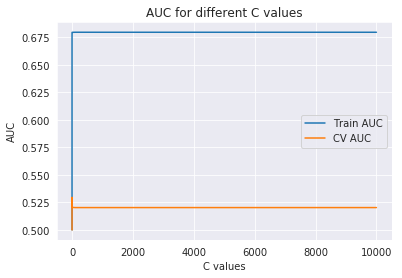

In [129]:
sns.set_style("darkgrid")
plt.plot(c, tr_list, label= 'Train AUC')
plt.plot(c,cv_list, label= 'CV AUC')
plt.xlabel("C values")
plt.ylabel("AUC")
plt.title("AUC for different C values")
plt.legend()
plt.show()

### Observation:
From the above table and data we can observe that the optimalvalue of C is 0.1 with CV AUC score of 0.529

In [130]:
lr = LogisticRegression(penalty='l2', C=0.1, n_jobs=-1)
lr.fit(train_sent_vectors, y_tr)
pred = lr.predict(test_sent_vectors)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 0.1 is %f%%' % (auc))


****Test auc for C = 0.1 is 0.577350%


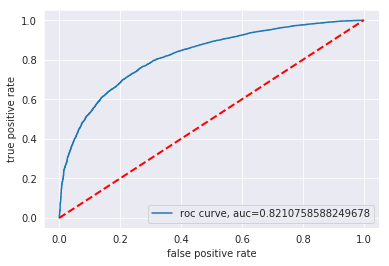

In [131]:
lw = 2
pred_proba = lr.predict_proba(test_sent_vectors)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  pred_proba)
auc = metrics.roc_auc_score(y_test, pred_proba)
plt.plot(fpr,tpr,label="roc curve, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.show()

### Obeservation:
The ROC curve of Avg W2V is above the random line and seperated by a good margin

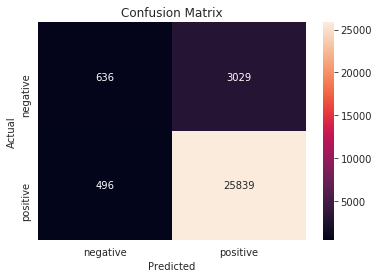

In [132]:
conf_matrix = confusion_matrix(y_test, pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Observation:
True Negative = 636, True Positive = 25839, False Negative = 496, False Positive = 3029

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [136]:
c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

tr_list = []
for i in c:
    lr = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    lr.fit(train_vectors, y_tr)
    pred = lr.predict(train_vectors)
    auc = roc_auc_score(y_tr, pred)
    tr_list.append(auc.mean())
    print('\nTrain auc for C = %f is %f%%' % (i, auc))
   
print('*'*100)

cv_list = []
for j in c:
    lr = LogisticRegression(penalty='l2', C=j, n_jobs=-1)
    lr.fit(train_vectors, y_tr)
    pred = lr.predict(cv_vectors)
    auc = roc_auc_score(y_cv, pred)
    cv_list.append(auc.mean())
    print('\nCV auc for C = %f is %f%%' % (j, auc))


Train auc for C = 0.000010 is 0.500000%

Train auc for C = 0.000100 is 0.500000%

Train auc for C = 0.001000 is 0.500000%

Train auc for C = 0.010000 is 0.500000%

Train auc for C = 0.100000 is 0.500000%

Train auc for C = 1.000000 is 0.500000%

Train auc for C = 10.000000 is 0.500000%

Train auc for C = 100.000000 is 0.500000%

Train auc for C = 1000.000000 is 0.500000%

Train auc for C = 10000.000000 is 0.500000%
****************************************************************************************************

CV auc for C = 0.000010 is 0.500000%

CV auc for C = 0.000100 is 0.500000%

CV auc for C = 0.001000 is 0.500000%

CV auc for C = 0.010000 is 0.500000%

CV auc for C = 0.100000 is 0.500000%

CV auc for C = 1.000000 is 0.500000%

CV auc for C = 10.000000 is 0.500000%

CV auc for C = 100.000000 is 0.500000%

CV auc for C = 1000.000000 is 0.500000%

CV auc for C = 10000.000000 is 0.500000%


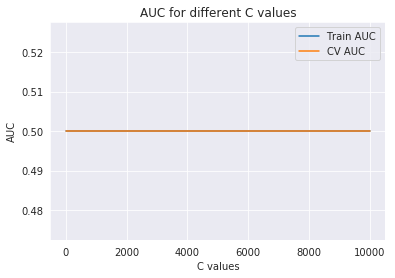

In [137]:
sns.set_style("darkgrid")
plt.plot(c, tr_list, label= 'Train AUC')
plt.plot(c,cv_list, label= 'CV AUC')
plt.xlabel("C values")
plt.ylabel("AUC")
plt.title("AUC for different C values")
plt.legend()
plt.show()

## Observation:

The AUC scores for all the values of C are same i.e., 0.50. Hence the optimal C = 0.000010

In [138]:
lr = LogisticRegression(penalty='l2', C=0.000010, n_jobs=-1)
lr.fit(train_sent_vectors, y_tr)
pred = lr.predict(test_sent_vectors)
auc = roc_auc_score(y_test, pred)
print('\n****Test auc for C = 0.000010 is %f%%' % (auc))


****Test auc for C = 0.000010 is 0.500000%


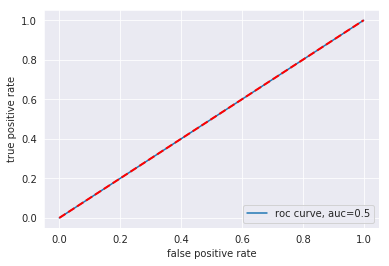

In [139]:
lw = 2
pred_proba = lr.predict_proba(test_vectors)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  pred_proba)
auc = metrics.roc_auc_score(y_test, pred_proba)
plt.plot(fpr,tpr,label="roc curve, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.show()

### Obeservation:
The ROC curve of TF-IDF W2V is on the random line. Hence, this is a random model

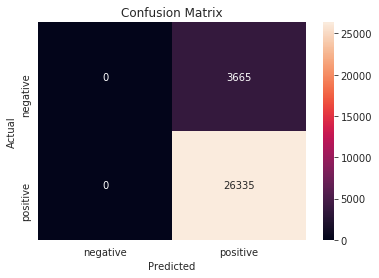

In [140]:
conf_matrix = confusion_matrix(y_test, pred)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# [6] Conclusions

In [4]:
# Please compare all your models using Prettytable library